# Constructing simple models of biochemical networks with BondGraphTools

In this notebook we introduce the basics of the BondGraphTools package and use it to construct simple bond graph representations of biochemical networks.

In [1]:
# Import packages
import BondGraphTools as bgt
from BondGraphTools.actions import new, add, connect
from BondGraphTools import draw, simulate
from numpy import log
import matplotlib.pyplot as plt
import sympy as sp
from sympy import init_printing
init_printing()

## A simple example
In this section we work with the simple biochemical reaction $A + B \rightleftharpoons C$. The bond graph for this system is shown below, where the bonds have been numbered in blue for ease of reference.

![](ABC.svg)

We begin by creating each of the components, and adding them to the model.

In [2]:
# Create a new model
model_ABC = new(name='ABC')

# Define the components
C_A = new(component='Ce',name='A',library='BioChem') # C:A
C_B = new(component='Ce',name='B',library='BioChem') # C:B
C_C = new(component='Ce',name='C',library='BioChem') # C:C
Re = new(component='Re',name='R1',library='BioChem') # Re:R1
flow = new(component='1',name='AB') # 1 junction

# Add components to the model
add(model_ABC,C_A,C_B,C_C,Re,flow)

# List the components to check they have been added
model_ABC.components

OrderedSet([C: A, C: B, C: C, R: R1, 1: AB])

Next we define the bonds that link the components together.

In [3]:
connect(C_A,flow) # Bond 1
connect(C_B,flow) # Bond 2
connect(flow,Re) # Bond 3
connect(Re,C_C) # Bond 4

# List the bonds to check they have been added
model_ABC.bonds

[Bond(tail=Port(C: A, 0), head=Port(1: AB, 0)),
 Bond(tail=Port(C: B, 0), head=Port(1: AB, 1)),
 Bond(tail=Port(1: AB, 2), head=Port(R: R1, 0)),
 Bond(tail=Port(R: R1, 1), head=Port(C: C, 0))]

We now draw the bond graph to make sure that the structure is the same as the diagram above.

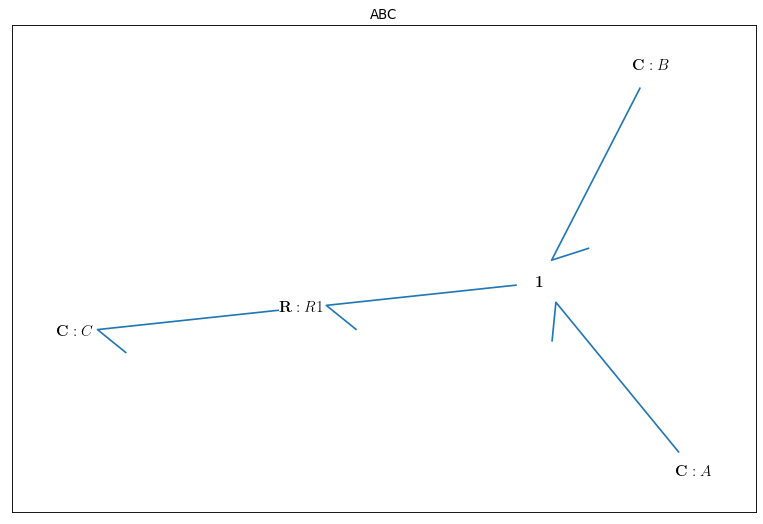

In [4]:
draw(model_ABC)

The differential equations for the model can be derived using the `constitutive_relations` property.

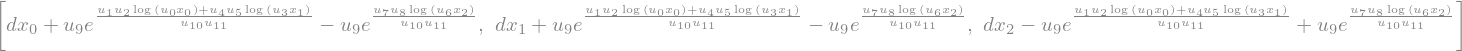

In [5]:
model_ABC.constitutive_relations

As seen above, the differential equations contain a number of unset constants - the control variables $u_n$. We will now set the parameters for each component, and derive the differential equation again.

In [6]:
# C:A
C_A.set_param('k',1)
C_A.set_param('R',1)
C_A.set_param('T',1)

# C:B
C_B.set_param('k',1)
C_B.set_param('R',1)
C_B.set_param('T',1)

# C:C
C_C.set_param('k',1)
C_C.set_param('R',1)
C_C.set_param('T',1)

# Re:R1
Re.set_param('r',1)
Re.set_param('R',1)
Re.set_param('T',1)

# Derive the differential equations
model_ABC.constitutive_relations

It is easily seen that the differential equations follow the law of mass action. The definition of each state can be found by using the `state_vars` method. The states $x_0$, $x_1$ and $x_2$ correspond to A, B and C respectively.

In [7]:
for k,v in model_ABC.state_vars.items(): print(f'{k} -> {v[0]}')

x_0 -> C: A
x_1 -> C: B
x_2 -> C: C


Therefore the differential equations can be interpreted as
$$ 
\begin{align*}
\frac{dx_A}{dt} &= -x_A x_B + x_C \\
\frac{dx_B}{dt} &= -x_A x_B + x_C \\
\frac{dx_C}{dt} &= x_A x_B - x_C 
\end{align*}
$$

We will now attempt to simulate the model using the `simulate` method in BondGraphTools. We set $x_0 = 1$, $x_1 = 2$ and $x_2 = 3$ as the initial conditions, and simulate the system from $t=0$ to $t=10$. The results are plotted below.

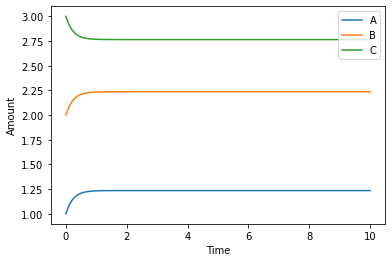

In [8]:
t,x = simulate(model_ABC, timespan=(0.,10.), x0=[1,2,3])
plt.plot(t,x)
plt.xlabel('Time')
plt.ylabel('Amount')
plt.legend(['A','B','C'])
plt.show()

We can run a different simulation for the same system using the initial conditions $x_0 = 3$, $x_1 = 1$ and $x_2 = 2$.

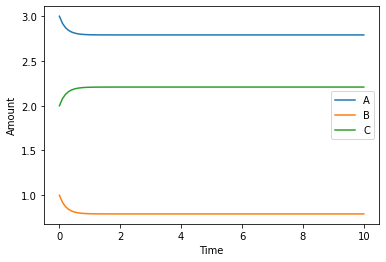

In [9]:
t,x = simulate(model_ABC, timespan=(0.,10.), x0=[3,1,2])
plt.plot(t,x)
plt.xlabel('Time')
plt.ylabel('Amount')
plt.legend(['A','B','C'])
plt.show()

## The reversible Michaelis-Menten model
Here we will create a bond graph of the two-state enzyme model used for the Michaelis-Menten equations. The chemical reactions in this system are 
$$
E + S \rightleftharpoons C \\ 
C \rightleftharpoons E + P
$$
As in the typical formulation, we assume that S and P are chemostats, i.e. their amounts are fixed at constant values. The corresponding bond graph for this system is shown below. The bonds have been labelled in blue.

![](enzyme_cycle.svg)

We begin by creating each of the components, and placing them in a list.

While we chose to initialise components without their parameters in the previous example, we use this example to demonstrate how to initialise components with their parameters. All the bond graph parameters have been set to 1, and we assume that S is fixed at an amount of 2, and P is fixed at an amount of 1.

In [10]:
model_MM = new(name='Michaelis-Menten')

R = 8.3144598
T = 310
K_S = 1
K_P = 1
x_S = 2
x_P = 1

# Chemical species
C_E = new(component='Ce',name='E',library='BioChem',value={'k':1,'R':R,'T':T})
C_C = new(component='Ce',name='C',library='BioChem',value={'k':1,'R':R,'T':T})
# Chemostats
Se_S = new(component='Se',name='S',value={'e':R*T*log(K_S*x_S)})
Se_P = new(component='Se',name='P',value={'e':R*T*log(K_P*x_P)})
# Reactions
R1 = new(component='Re',name='R1',library='BioChem',value={'r':1,'R':R,'T':T})
R2 = new(component='Re',name='R2',library='BioChem',value={'r':1,'R':R,'T':T})
# 0 junctions
ej_E = new(component='0',name='E')
ej_C = new(component='0',name='C')
# 1 junctions
fj_1 = new(component='1',name='R1')
fj_2 = new(component='1',name='R2')

# Place components in a list and add to model
components = [C_E,C_C,Se_S,Se_P,R1,R2,ej_E,ej_C,fj_1,fj_2]
add(model_MM, *components)

# Check that the components are in the model
model_MM.components

OrderedSet([C: E, C: C, SS: S, SS: P, R: R1, R: R2, 0: E, 0: C, 1: R1, 1: R2])

We next connect the components together, as in the diagram above.

In [11]:
connect(Se_S,fj_1) # Bond 1
connect(fj_1,(R1,0)) # Bond 2
connect((R1,1),ej_C) # Bond 3
connect(ej_C,C_C) # Bond 4
connect(ej_C,(R2,0)) # Bond 5
connect((R2,1),fj_2) # Bond 6
connect(fj_2,Se_P) # Bond 7
connect(fj_2,ej_E) # Bond 8
connect(ej_E,C_E) # Bond 9
connect(ej_E,fj_1) # Bond 10

# Check that the bonds have been added
model_MM.bonds

[Bond(tail=Port(SS: S, 0), head=Port(1: R1, 0)),
 Bond(tail=Port(1: R1, 1), head=Port(R: R1, 0)),
 Bond(tail=Port(R: R1, 1), head=Port(0: C, 0)),
 Bond(tail=Port(0: C, 1), head=Port(C: C, 0)),
 Bond(tail=Port(0: C, 2), head=Port(R: R2, 0)),
 Bond(tail=Port(R: R2, 1), head=Port(1: R2, 0)),
 Bond(tail=Port(1: R2, 1), head=Port(SS: P, 0)),
 Bond(tail=Port(1: R2, 2), head=Port(0: E, 0)),
 Bond(tail=Port(0: E, 1), head=Port(C: E, 0)),
 Bond(tail=Port(0: E, 2), head=Port(1: R1, 2))]

The bond graph drawn by the software verifies these connections.

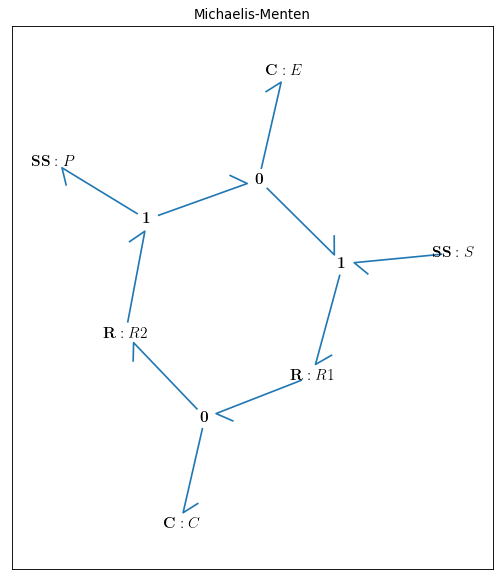

In [12]:
draw(model_MM)

For this model, the constitutive equations reduce to a linear system

In [13]:
model_MM.constitutive_relations

with the state variables defined as

In [14]:
for k,v in model_MM.state_vars.items(): print(f'{k} -> {v[0]}')

x_0 -> C: E
x_1 -> C: C


We may now simulate this model using the initial conditions $x_E = 1$ and $x_C = 2$.

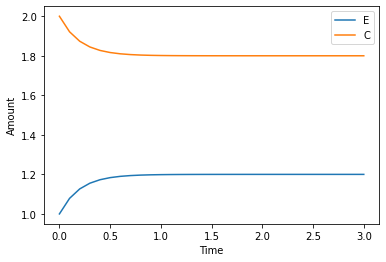

In [15]:
t,x = simulate(model_MM, timespan=(0.,3.), x0=[1,2])
plt.plot(t,x)
plt.xlabel('Time')
plt.ylabel('Amount')
plt.legend(['E','C'])
plt.show()

We may also run a simulation where the amount of substrate is gradually increased, i.e. $x_S = 1+t$. We turn the **Se:S** component back into a controlled variable, and set the effort to be $e = RT\ln(K_S (1+t))$. As the amount of substrate increases more of the enzyme is driven to the complex state.

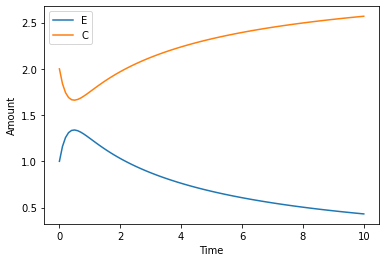

In [16]:
Se_S.set_param('e',None)
t,x = simulate(model_MM, timespan=(0.,10.), x0=[1,2], control_vars={'u_0':f'{R}*{T}*log({K_S}*(1+t))'})
plt.plot(t,x)
plt.xlabel('Time')
plt.ylabel('Amount')
plt.legend(['E','C'])
plt.show()